In [1]:
import re
import json
import random
from pprint import pprint
from ast import literal_eval
from collections import Counter

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
random.seed(2021)
np.random.seed(2021)

In [3]:
exportdata = pd.read_csv("exportdata.csv")
entries = pd.read_csv("entries_of_projects_chosen_by_patrice.csv")
af_widgets = pd.read_csv("af_widgets_of_interest.csv")
projects = pd.read_csv("projects_chosen_by_patrice.csv")
exportables = pd.read_csv("af_exportables.csv")
##
afs = pd.read_csv("analysis_frameworks.csv")
users = pd.read_csv("user_names.csv")
##
matching = pd.read_csv("pillars_subpillars_matching.csv")

In [4]:
project_list = pd.read_csv("extended_project_list.csv")

In [5]:
af_widgets["properties"] = af_widgets["properties"].apply(json.loads)

In [6]:
af_widgets["title"].str.upper().unique()

array(['SECTORAL INFORMATION', 'LOCATION', 'EXCERPT',
       'OPERATIONAL ENVIRONMENT', 'INFORMATION DATE', 'RELIABILITY',
       'FLAG', 'DEMOGRAPHIC GROUPS', 'SPECIFIC NEEDS GROUPS',
       'AFFECTED GROUPS', 'SEVERITY', 'SECTORS', 'CROSS SECTOR',
       'GEO LOCATION', 'PRE-CRISIS', 'IN-CRISIS', 'CRISIS TYPE',
       'CONTEXT ADDITIONAL TAGS', 'SHOCK/EVENT', 'ADDITIONAL CONTEXT',
       'DISPLACED POP TYPE', 'CLEANING TAGS', 'POPULATION GROUPS',
       'CLEANING COMMENTS', 'HIGH LEVEL TAGS', 'COMMENT'], dtype=object)

In [7]:
mat2d_titles = [
    s.upper() for s in [
        "Pre-Crisis",
        "Shock/Event",
        "In-Crisis",
        "Sectors",
        "Sectoral Information",
        "Matrix 2D",
    ]
]
mat2d_properties_ids = af_widgets[(
    af_widgets["title"].str.upper()).isin(mat2d_titles)][[
        "properties", "analysis_framework_id"
    ]]
mat2d_properties = mat2d_properties_ids["properties"].tolist()
mat2d_ids = mat2d_properties_ids["analysis_framework_id"].tolist()

In [8]:
afids_pillars_subpillars = dict()
for mat, af_id in zip(mat2d_properties, mat2d_ids):
    dims = mat["data"]['dimensions']
    afids_pillars_subpillars[af_id] = {}
    for dim in dims:
        pillar = dim["title"]
        sub_pillars = []
        for sub_pillar_dict in dim["subdimensions"]:
            sub_pillars.append(sub_pillar_dict["title"])
        afids_pillars_subpillars[af_id][pillar] = sub_pillars


In [9]:
exportables["data"] = exportables["data"].apply(literal_eval)

In [10]:
def extract_title(x):
    if x["excel"].get("title"):
        return x["excel"]["title"]
    elif x["excel"].get("type") == "multiple":
        return x["excel"]["titles"]

af_titles = exportables["data"].apply(extract_title).tolist()

In [11]:
entries.shape, exportdata.shape

((181142, 21), (1018086, 4))

In [12]:
entries[~entries["excerpt"].isna()]["excerpt"].unique().shape

(138924,)

In [13]:
exid_to_exdata = dict()
for ex_id, ex_data in zip(exportables["id"], exportables["data"]):
    exid_to_exdata[ex_id] = ex_data

In [14]:
# additional tags:
# Reliability, Severity, geo location, crisis type, affected groups, 

In [15]:
af_widgets["title"].unique()

array(['Sectoral Information', 'LOCATION', 'EXCERPT',
       'Operational Environment', 'Information Date', 'RELIABILITY',
       'Flag', 'DEMOGRAPHIC GROUPS', 'SPECIFIC NEEDS GROUPS',
       'AFFECTED GROUPS', 'Severity', 'Sectors', 'Cross sector',
       'Affected groups', 'Specific Needs Groups', 'Demographic Groups',
       'Reliability', 'Geo Location', 'Excerpt', 'Information date',
       'PRE-CRISIS', 'IN-CRISIS', 'Crisis type',
       'Context additional tags', 'Crisis Type', 'SHOCK/EVENT',
       'Additional Context', 'DISPLACED POP TYPE', 'CLEANING tags',
       'POPULATION GROUPS', 'Cleaning comments', 'HIGH LEVEL TAGS',
       'Comment'], dtype=object)

In [16]:
widget_key_id_to_title = dict()
for w_key, w_id, title in zip(af_widgets["key"], af_widgets["widget_id"], af_widgets["title"]):
    widget_key_id_to_title[(w_key, w_id)] = title

In [17]:
def exportdata_to_tag_title(row):
    data = json.loads(row[1])
    wkey, wid = None, None
    if data.get("common"):
        wkey = data.get("common").get("widget_key")
        wid = data["common"].get("widget_id")
    if wkey and wid:
        if widget_key_id_to_title.get((wkey, wid)):
            return widget_key_id_to_title.get((wkey, wid))
    if data.get("report") and data["report"].get("other"):
            if len(data["report"]["other"]) == 1 and data["report"]["other"][0].get("title"):
                if data["report"]["other"][0]["title"]:
                    return data["report"]["other"][0]["title"]
    if isinstance(data.get("excel"), list) and len(data["excel"])==1 and \
     data["excel"][0].get("widget_key") and data["excel"][0].get("widget_id"):
        wkey = data["excel"][0]["widget_key"]
        wid = data["excel"][0]["widget_id"]
        if widget_key_id_to_title.get((wkey, wid)):
            return widget_key_id_to_title.get((wkey, wid))
    exportable_id = row[3]
    if exid_to_exdata[exportable_id]["excel"].get("title"):
        return exid_to_exdata[exportable_id]["excel"]["title"]
    elif exid_to_exdata[exportable_id]["excel"].get("type") == "multiple":
        return exid_to_exdata[exportable_id]["excel"]["titles"]
    raise

In [18]:
exportdata["tag_title"] = exportdata.apply(exportdata_to_tag_title, axis=1)

In [19]:
def exportdata_to_tag_value(row):
    data = json.loads(row[1])
    if isinstance(data["excel"], list) and len(data["excel"])==1:
        return data["excel"][0]["value"]
    if data["excel"].get("type") == "lists":
        return data["excel"]["values"]
    if isinstance(data["excel"], dict) and "value" in data["excel"]:
        return data["excel"].get("value")
    if isinstance(data["excel"], dict) and "values" in data["excel"]:
        return data["excel"].get("values")
    elif "values" in data["common"]:
        return data["common"]["values"]
    elif "value" in data["common"]:
        return data["common"]["value"]
    raise

In [20]:
exportdata["tag_value"] = exportdata.apply(exportdata_to_tag_value, axis=1)

In [21]:
def title_case(tag):
    if isinstance(tag, (list, tuple)):
        return tuple([x.title() for x in tag])
    return tag.title()

In [22]:
exportdata["tag_title"] = exportdata["tag_title"].apply(title_case)

In [23]:
exportdata.tag_title.unique()

array(['Severity', 'Reliability', 'Population Groups', 'Information Date',
       'Location', 'Sectoral Information', 'Demographic Groups', 'Flag',
       'Operational Environment', 'Shock/Event', 'High Level Tags',
       'In-Crisis', 'Specific Needs Groups', 'Comment',
       'Additional Context', 'Sectors', 'Cross Sector', 'Geo Location',
       'Affected Groups', 'Displaced Pop Type', 'Crisis Type',
       'Cleaning Tags', 'Displacement Profile Details',
       ('Affected Groups - Level 0', 'Affected Groups - Level 1', 'Affected Groups - Level 2', 'Affected Groups - Level 3'),
       'Cleaning Comments',
       ('Sectoral Information - Dimension', 'Sectoral Information - Subdimension', 'Sectoral Information - Sector', 'Sectoral Information - Subsectors'),
       ('Information Date (From)', 'Information Date (To)'),
       ('Operational Environment - Dimension', 'Operational Environment - Subdimension'),
       ('In-Crisis - Dimension', 'In-Crisis - Subdimension', 'In-Crisis - Secto

In [24]:
#exportdata["tag_title"].unique()
# 1. GIMAC --> Pre-Crisis, Shock/Event, In-Crisis
# 2. 2020 Okular --> Sectoral Information
# 3. Okular Analytics Generic --> Sectoral Information
# 4. Rohingya Framework --> Sectors
# 5. IFRC 2018 --> Sectors
# 6. Colombia AF --> Sectoral Information
# 7. Nigeria Situation Analysis (OA) --> Sectoral Information
# 8. Situation Analysis Generic Yemen --> Matrix 2D
# 9. Situation Analysis Generic Libya --> Sectors

In [25]:
secondary_tags_titles = [
        "Severity",
        "Reliability",
        "Demographic Groups",
        "Specific Needs Groups",
        "Location",
        "Information Date"
]

In [26]:
exportdata_secondary_tags = exportdata[exportdata["tag_title"].isin(secondary_tags_titles)]

In [27]:
exportdata_secondary_tags.shape, exportdata.shape, entries.shape

((659058, 6), (1018086, 6), (181142, 21))

In [28]:
entries_labeled_secondary_tags = pd.merge(entries,
                                 exportdata_secondary_tags,
                                 how="inner",
                                 left_on="id",
                                 right_on="entry_id",
                                 suffixes=('_entry', '_exportdata'))

In [29]:
entries.shape, entries[~entries["excerpt"].isna()]["excerpt"].unique().shape

((181142, 21), (138924,))

In [30]:
leads = entries_labeled_secondary_tags.lead_id.unique()

In [31]:
entries_labeled_secondary_tags_cleaned =\
                entries_labeled_secondary_tags[~entries_labeled_secondary_tags["excerpt"].isna()]\
                                    .drop(columns=['tabular_field_id',
                                                   'image_id',
                                                   'image_raw', 
                                                   'created_at', 
                                                   'modified_at', 
                                                   'created_by_id', 
                                                   'modified_by_id',
                                                   'entry_type', 
                                                   'dropped_excerpt', 
                                                   'highlight_hidden', 
                                                   'verified', 
                                                   'verification_last_changed_by_id', 
                                                   'client_id',
                                                   'id_exportdata',
                                                   'information_date',
                                                   'order',
                                                   'id_entry',
                                                   'data'])

In [32]:
entries_labeled_secondary_tags_cleaned.shape, entries_labeled_secondary_tags_cleaned.columns

((501220, 9),
 Index(['excerpt', 'analysis_framework_id', 'lead_id', 'project_id', 'title',
        'entry_id', 'exportable_id', 'tag_title', 'tag_value'],
       dtype='object'))

In [33]:
entries_labeled_secondary_tags_cleaned.tag_title.unique()

array(['Information Date', 'Reliability', 'Severity', 'Location',
       'Demographic Groups', 'Specific Needs Groups'], dtype=object)

In [34]:
entries_labeled_secondary_tags_cleaned.head(2)

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_title,tag_value
0,"On March 19, search-andrescue personnel airlif...",273,10607,878,"IFRC - Cyclone Idai, March 2019",25639,3148,Information Date,22-03-2019
1,"On March 19, search-andrescue personnel airlif...",273,10607,878,"IFRC - Cyclone Idai, March 2019",25639,3145,Reliability,Usually


In [35]:
reliability_raw_to_processed_dict = {
    'Completely':'Completely Reliable',
    'Completely Reliable':'Completely Reliable',
    'Usually Reliable':'Usually reliable',
    'Usually':'Usually reliable',
    'Fairly Reliable':'Fairly Reliable',
    'Fairly':'Fairly Reliable',
    'Not Usually':'Not Usually Reliable',
    'Not Usually Reliable':'Not Usually Reliable',
    'Unreliable':'Unreliable',
    'Cannot be Used':'Unreliable',
    'Unreliable ':'Unreliable'
}

In [36]:
reliabillity_tags_df = entries_labeled_secondary_tags_cleaned[entries_labeled_secondary_tags_cleaned.tag_title=='Reliability']\
                            .drop(columns=['tag_title'])
reliabillity_tags_df['tag_value'] =\
            reliabillity_tags_df['tag_value'].apply(lambda x: reliability_raw_to_processed_dict[x])

In [37]:
reliabillity_tags_df.head(2)

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_value
1,"On March 19, search-andrescue personnel airlif...",273,10607,878,"IFRC - Cyclone Idai, March 2019",25639,3145,Usually reliable
9,"Currently, there are 139,771 confirmed cases i...",699,28940,1142,IFRC Turkey,102051,5295,Usually reliable


Text(0.5, 0, 'proportion')

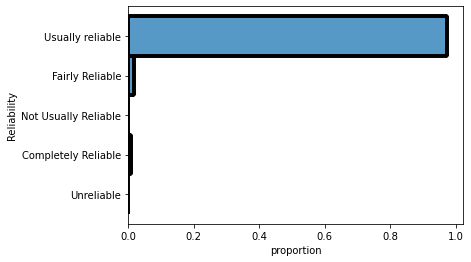

In [38]:

sns.histplot(data=reliabillity_tags_df, y="tag_value", stat='probability')
plt.ylabel('Reliability')
plt.xlabel('proportion')

In [39]:
reliabillity_tags_df.to_csv('data_secondary_tags/reliabillity_tags.csv')

## Dates

In [40]:
date_tags_df =\
    entries_labeled_secondary_tags_cleaned[entries_labeled_secondary_tags_cleaned.tag_title=='Information Date']\
                            .drop(columns=['tag_title'])

date_tags_df = date_tags_df[date_tags_df.tag_value.apply(
                    lambda x: x!=None and x!=[None, None]
            )]

In [41]:
date_tags_df.head()

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_value
0,"On March 19, search-andrescue personnel airlif...",273,10607,878,"IFRC - Cyclone Idai, March 2019",25639,3148,22-03-2019
11,"Currently, there are 139,771 confirmed cases i...",699,28940,1142,IFRC Turkey,102051,5300,"[11-05-2020, None]"
84," Mt. Pinatubo eruption, June 1991, Atmosphere...",699,12919,1111,IFRC Philippines,33155,5300,"[01-06-1991, None]"
89,"In addition, there are 922,530* foreign nation...",699,26544,1142,IFRC Turkey,96087,5300,"[01-01-2019, 31-03-2020]"
98,"""He has the support, up until now, of the arme...",273,10740,786,Venezuela crisis 2019,26269,3148,23-03-2019


In [42]:
date_tags_df.to_csv('data_secondary_tags/date_tags.csv')


## Locations:

In [43]:
geoarea_df = pd.read_csv('geo_geoarea.csv')

In [44]:
geo_location_data =\
    entries_labeled_secondary_tags_cleaned[
        entries_labeled_secondary_tags_cleaned.tag_title.apply(lambda x: "Location" in (x))
    ].drop(columns=['tag_title'])
geo_location_data.head()

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_value
8,"Currently, there are 139,771 confirmed cases i...",699,28940,1142,IFRC Turkey,102051,5304,[215265]
17,"According to The Guardian, more than 9,000 ref...",552,8644,788,Nigeria Situation Analysis (OA),21660,4691,[29687]
36,SANCAKTEPE SUB-PROVINCE: According to Baseline...,699,25511,1142,IFRC Turkey,96070,5304,[215807]
82," Mt. Pinatubo eruption, June 1991, Atmosphere...",699,12919,1111,IFRC Philippines,33155,5304,[221420]
87,"In addition, there are 922,530* foreign nation...",699,26544,1142,IFRC Turkey,96087,5304,[215265]


In [45]:
list_dicts = geoarea_df[['id', 'title']].to_dict(orient='split')['data']
id_to_location = {}
for row in list_dicts:
    id_to_location[row[0]] = row[1]
list_keys = list(id_to_location.keys())

In [46]:
def perfectEval(anonstring):
    corrected = [int(nb) for nb in anonstring]
    return corrected

In [47]:
geo_location_data['tag_value'] = geo_location_data['tag_value'].apply(lambda x: perfectEval(x))

In [ ]:
n = 1000
final_df = pd.DataFrame()
for i in tqdm(range(0,geo_location_data.shape[0],n)):
    tmp_df = geo_location_data[i:i+n].copy()
    tmp_df['tag_value'] = tmp_df.tag_value\
                            .apply(lambda x: [id_to_location[int(tag_)] for tag_ in x if int(tag_) in list_keys])
    final_df = final_df.append(tmp_df)

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
final_df = final_df[final_df.tag_value.apply(lambda x: bool(len(x)) and 'Unknown' not in x)]

In [ ]:
final_df.to_csv('data_secondary_tags/geo_location.csv')

In [ ]:
#geo_location_df.to_csv('data_secondary_tags/geo_location.csv')

## Severity

In [ ]:
Severity_raw_to_processed_dict = {
    'Critical':'Critical',
    'Severe':'Critical',
    'Critical Situation':'Critical',
    'Critical problem. Urgent intervention required':'Critical',
    'Severe Conditions':'Critical',
    'Major':'Major',
    'Severe Problem. Intervention required':'Major',
    'Important problem. Middle to short term intervention required':'Major',
    'Situation of Major Concern':'Major',
    'Of Concern. Monitoring required':'Of Concern',
    'Of Concern':'Of Concern',
    'Situation of Concern':'Of Concern',
    'No Problem':'No problem',
    'Minor Problem':'Minor Problem',
    None:None
    
}

In [ ]:
severity_tags_df = entries_labeled_secondary_tags_cleaned[entries_labeled_secondary_tags_cleaned.tag_title=='Severity']\
                            .drop(columns=['tag_title'])

severity_tags_df = severity_tags_df[
    severity_tags_df.tag_value.apply(lambda x: (x!='No problem/minor problem. No intervention required') and\
                                    (x!='No problem/Minor Problem'))]

severity_tags_df['tag_value'] =\
            severity_tags_df['tag_value'].apply(lambda x: Severity_raw_to_processed_dict[x])

severity_tags_df = severity_tags_df.dropna()

In [ ]:
severity_tags_df.head()

In [ ]:

sns.histplot(data=severity_tags_df, y="tag_value")
plt.ylabel('Severity')
plt.xlabel('number of entries')

In [ ]:
severity_tags_df = severity_tags_df.dropna()
severity_tags_df.to_csv('data_secondary_tags/severity_tags.csv')

In [ ]:
Specific_needs_groups_raw_to_processed_dict = {
    ' Separated Children':'Unaccompanied or Separated Children',
    'Separated Children':'Unaccompanied or Separated Children',
    'Unaccompanied Children (without caregiver)':'Unaccompanied or Separated Children',
    'Unaccompanied Children (without Caregiver)':'Unaccompanied or Separated Children',
    'Unaccompanied or Separated Children (UASC)':'Unaccompanied or Separated Children',
    'Child Head of Household':'Child Head of Household',
    'Elderly Head of Household':'Elderly Head of Household',
    'Female Head of Household':'Female Head of Household',
    'GBV survivors':'GBV survivors',
    'Pregnant or Lactating Women':'Pregnant or Lactating Women',
    'Single Women (including Widows)':'Single Women (including Widows)',
    'Ethnic minority':'Minorities',
    'Indigenous people':'Indigenous people',
    'LGBTQI':'LGBTQI+',
    'LGBTQI community member':'LGBTQI+',
    'LGBTQI+':'LGBTQI+',
    'Minorities':'Minorities',
    'Religious minority':'Minorities',
    'Unregistered Refugee':'Unregistered Refugee',
    'No legal documentation':'No legal documentation',
    'People with irregular status':'People with irregular status',
    'Stateless':'People with irregular status',
    'Person with Disabilities':'Persons with Disability',
    'Persons with Disability':'Persons with Disability',
    'Chronically Ill':'Chronically Ill',
    'Chronically ill':'Chronically Ill'
}

In [ ]:
specific_needs_groups_tags_df = entries_labeled_secondary_tags_cleaned[
    entries_labeled_secondary_tags_cleaned.tag_title=='Specific Needs Groups']\
                            .drop(columns=['tag_title'])

specific_needs_groups_tags_df['tag_value'] =\
            specific_needs_groups_tags_df['tag_value']\
                .apply(lambda list_tags: [Specific_needs_groups_raw_to_processed_dict[tag] for tag in list_tags])

specific_needs_groups_tags_df['tag_value'] =\
            specific_needs_groups_tags_df['tag_value'].apply(lambda x: list(np.unique(x)))

In [ ]:
secondary_tags_df = entries_labeled_secondary_tags_cleaned
secondary_tags_df[secondary_tags_df.tag_title=='Specific Needs Groups'].tag_value\
                        .apply(lambda list_tags: [Specific_needs_groups_raw_to_processed_dict[tag] for tag in list_tags])

In [ ]:
specific_needs_groups_tags_df.to_csv('data_secondary_tags/specific_needs_groups_tags.csv')

In [ ]:
values_specific = list(Specific_needs_groups_raw_to_processed_dict.values())

In [ ]:
lengthes_dict = {}
for value in values_specific:

    len_tmp = specific_needs_groups_tags_df[specific_needs_groups_tags_df.tag_value\
                               .apply(lambda x: value in x)].shape[0]
    lengthes_dict[value]=len_tmp

In [ ]:
plt.barh(list(lengthes_dict.keys()), list(lengthes_dict.values()), 1)
plt.xlabel('number of occurences')
plt.title('Specifics needs Groups')

In [ ]:
Demographic_groups_raw_to_processed_dict = {
    'Adult (18 to 59 years old)':'Adult Unspecified gender (18-59 years old)',
    'Adult (18-59 years old)':'Adult Unspecified gender (18-59 years old)',
    'Adult Female (18 to 59 years old)':'Adult Female (18 to 59 years old)',
    'Adult female (18 to 59 years old)':'Adult Female (18 to 59 years old)',
    'Adult female (18-59 years old)':'Adult Female (18 to 59 years old)',
    'Adult Male (18 to 59 years old)':'Adult Male (18 to 59 years old)',
    'Adult (25 to 59 years old)':'Adult Unspecified gender (18-59 years old)',
    'Youth (18 to 24 years old)':'Adult Unspecified gender (18-59 years old)',
    'Adult Female (25 to 59 years old)':'Adult Female (18 to 59 years old)',
    'Adult Male (25 to 59 years old)':'Adult Male (18 to 59 years old)',
    'Youth Female (18 to 24 years old)':'Adult Female (18 to 59 years old)',
    'Youth Male (18 to 24 years old)':'Adult Male (18 to 59 years old)',
    'Adult male (18-59 years old)':'Adult Male (18 to 59 years old)',
    
    'Female Older Persons (60+ years old)':'Older Persons Female (60+ years old)',
    'Male Older Persons (60+ years old)':'Older Persons Male (60+ years old)',
    'Older Persons (60+ years old)':'Older Persons Unspecified gender (60+ years old)',
    'Older Persons Female (60+ years old)':'Older Persons Female (60+ years old)',
    'Older Persons Male (60+ years old)':'Older Persons Male (60+ years old)',
    'Older persons (60+ years old)':'Older Persons Unspecified gender (60+ years old)',
    'Older persons female (60+ years old)':'Older Persons Female (60+ years old)',
    'Older persons male (60+ years old)':'Older Persons Male (60+ years old)',
    
    'Infants/Toddlers (<5 years old)':'Infants/Toddlers (<5 years old)',
    'Infants/toddlers (<5)':'Infants/Toddlers (<5 years old)',
    'Infants (0-2 years old)':'Infants/Toddlers (<5 years old)',
    'Children (0-4 years old)':'Infants/Toddlers (<5 years old)',
    
    #'Children Male (5 to 1 years old) 
    'Children (5 to 11 years old)':'Children/Youth Unspecified gender (5 to 17 years old)',
    'Children (5 to 17 years old)':'Children/Youth Unspecified gender (5 to 17 years old)',
    'Children (5-11 years old)':'Children/Youth Unspecified gender (5 to 17 years old)',
    'Children (< 18 years)':'Children/Youth Unspecified gender (5 to 17 years old)',
    'Children Female  <18 years old':'Children/Youth Female (5 to 17 years old)',
    'Children Female (5 to 11 years old)':'Children/Youth Female (5 to 17 years old)',
    'Children Female (5 to 17 years old)':'Children/Youth Female (5 to 17 years old)',
    'Children Female (< 18 years)':'Children/Youth Female (5 to 17 years old)',
    'Children Male (5 to 11 years old)':'Children/Youth Male (5 to 17 years old)',
    'Children Male (< 18 years)':'Children/Youth Male (5 to 17 years old)',
    'Children Male < 18 years old':'Children/Youth Male (5 to 17 years old)',
    'Children female (5-11 years old)':'Children/Youth Female (5 to 17 years old)',
    'Children male (5-11 years old)':'Children/Youth Male (5 to 17 years old)',
    'Youth (12 to 17 years old)':'Children/Youth Unspecified gender (5 to 17 years old)',
    'Youth (12-17 years old)':'Children/Youth Unspecified gender (5 to 17 years old)',
    'Youth Female (12 to 17 years old)':'Children/Youth Female (5 to 17 years old)',
    'Youth Male (12 to 17 years old)':'Children/Youth Male (5 to 17 years old)',
    'Youth female (12-17 years old)':'Children/Youth Female (5 to 17 years old)',
    'Youth male (12-17 years old)':'Children/Youth Male (5 to 17 years old)',
}

In [ ]:
import numpy as np
np.unique(list(Demographic_groups_raw_to_processed_dict.values()))

In [ ]:
demographic_groups_tags_df = entries_labeled_secondary_tags_cleaned[entries_labeled_secondary_tags_cleaned.tag_title=='Demographic Groups']\
                            .drop(columns=['tag_title'])
demographic_groups_tags_df['tag_value'] =\
            demographic_groups_tags_df['tag_value']\
                .apply(lambda list_tags: [Demographic_groups_raw_to_processed_dict[tag] for tag in list_tags if (tag!='Children Male (5 to 1 years old)' and tag!='Female' and tag!='Male')])



In [ ]:
demographic_groups_tags_df.to_csv('data_secondary_tags/demographics_groups_tags_initial.csv')

In [ ]:
values_demographic = list(Demographic_groups_raw_to_processed_dict.values())

In [ ]:
lengthes_dict = {}
for value in values_demographic:

    len_tmp = demographic_groups_tags_df[demographic_groups_tags_df.tag_value\
                               .apply(lambda x: value in x)].shape[0]
    lengthes_dict[value]=len_tmp

In [ ]:
lengthes_dict

In [ ]:
plt.barh(list(lengthes_dict.keys()), list(lengthes_dict.values()), 1)
plt.xlabel('number of occurences')
plt.title('Demographic Groups')

In [ ]:
final_df